# Imports and GPU Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os

from models.trained_models.unet_wavelet import UNetWavelet
from torchsummary import summary

from utils.image_helpers import plot_image_grid, get_images, image_to_tensor, tensor_to_image
from simulation.SimulationPipeline import SimulationPipeline
from models.model_creation import create_model_from_configuration
from fitting.Fitter import create_fitter_from_configuration
from fitting.Result import generate_rudimentary_result
from utils.configuration_parser.fit_model_configuration import get_fit_model_configuration
from utils.evaluation_helpers import performance_from_images, average_performances

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    os.environ['CUDA_VISIBLE_DEVICES'] = '2'
    print("num GPUs",torch.cuda.device_count())
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

num GPUs 1


# Load & Simulate Images

In [2]:
number_of_images = 20
image_size = 100
k_factors = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0]
snr = 64
pf_factor = 1.0
path = 'data/imagenet_v2_top_images'

In [3]:
original_images = get_images(path, max_amount=number_of_images, size=image_size)

noisy_images = []
target_images = []
image_ids = []
for k_factor in k_factors:
    pipeline = SimulationPipeline(k_factor=k_factor, snr=snr, pf_factor=pf_factor)
    noisy_images_k = pipeline.simulate_list(original_images)
    noisy_images += noisy_images_k
    target_images += original_images
    image_ids += [{'k_factor': k_factor}] * number_of_images

10000  images found in  data/imagenet_v2_top_images


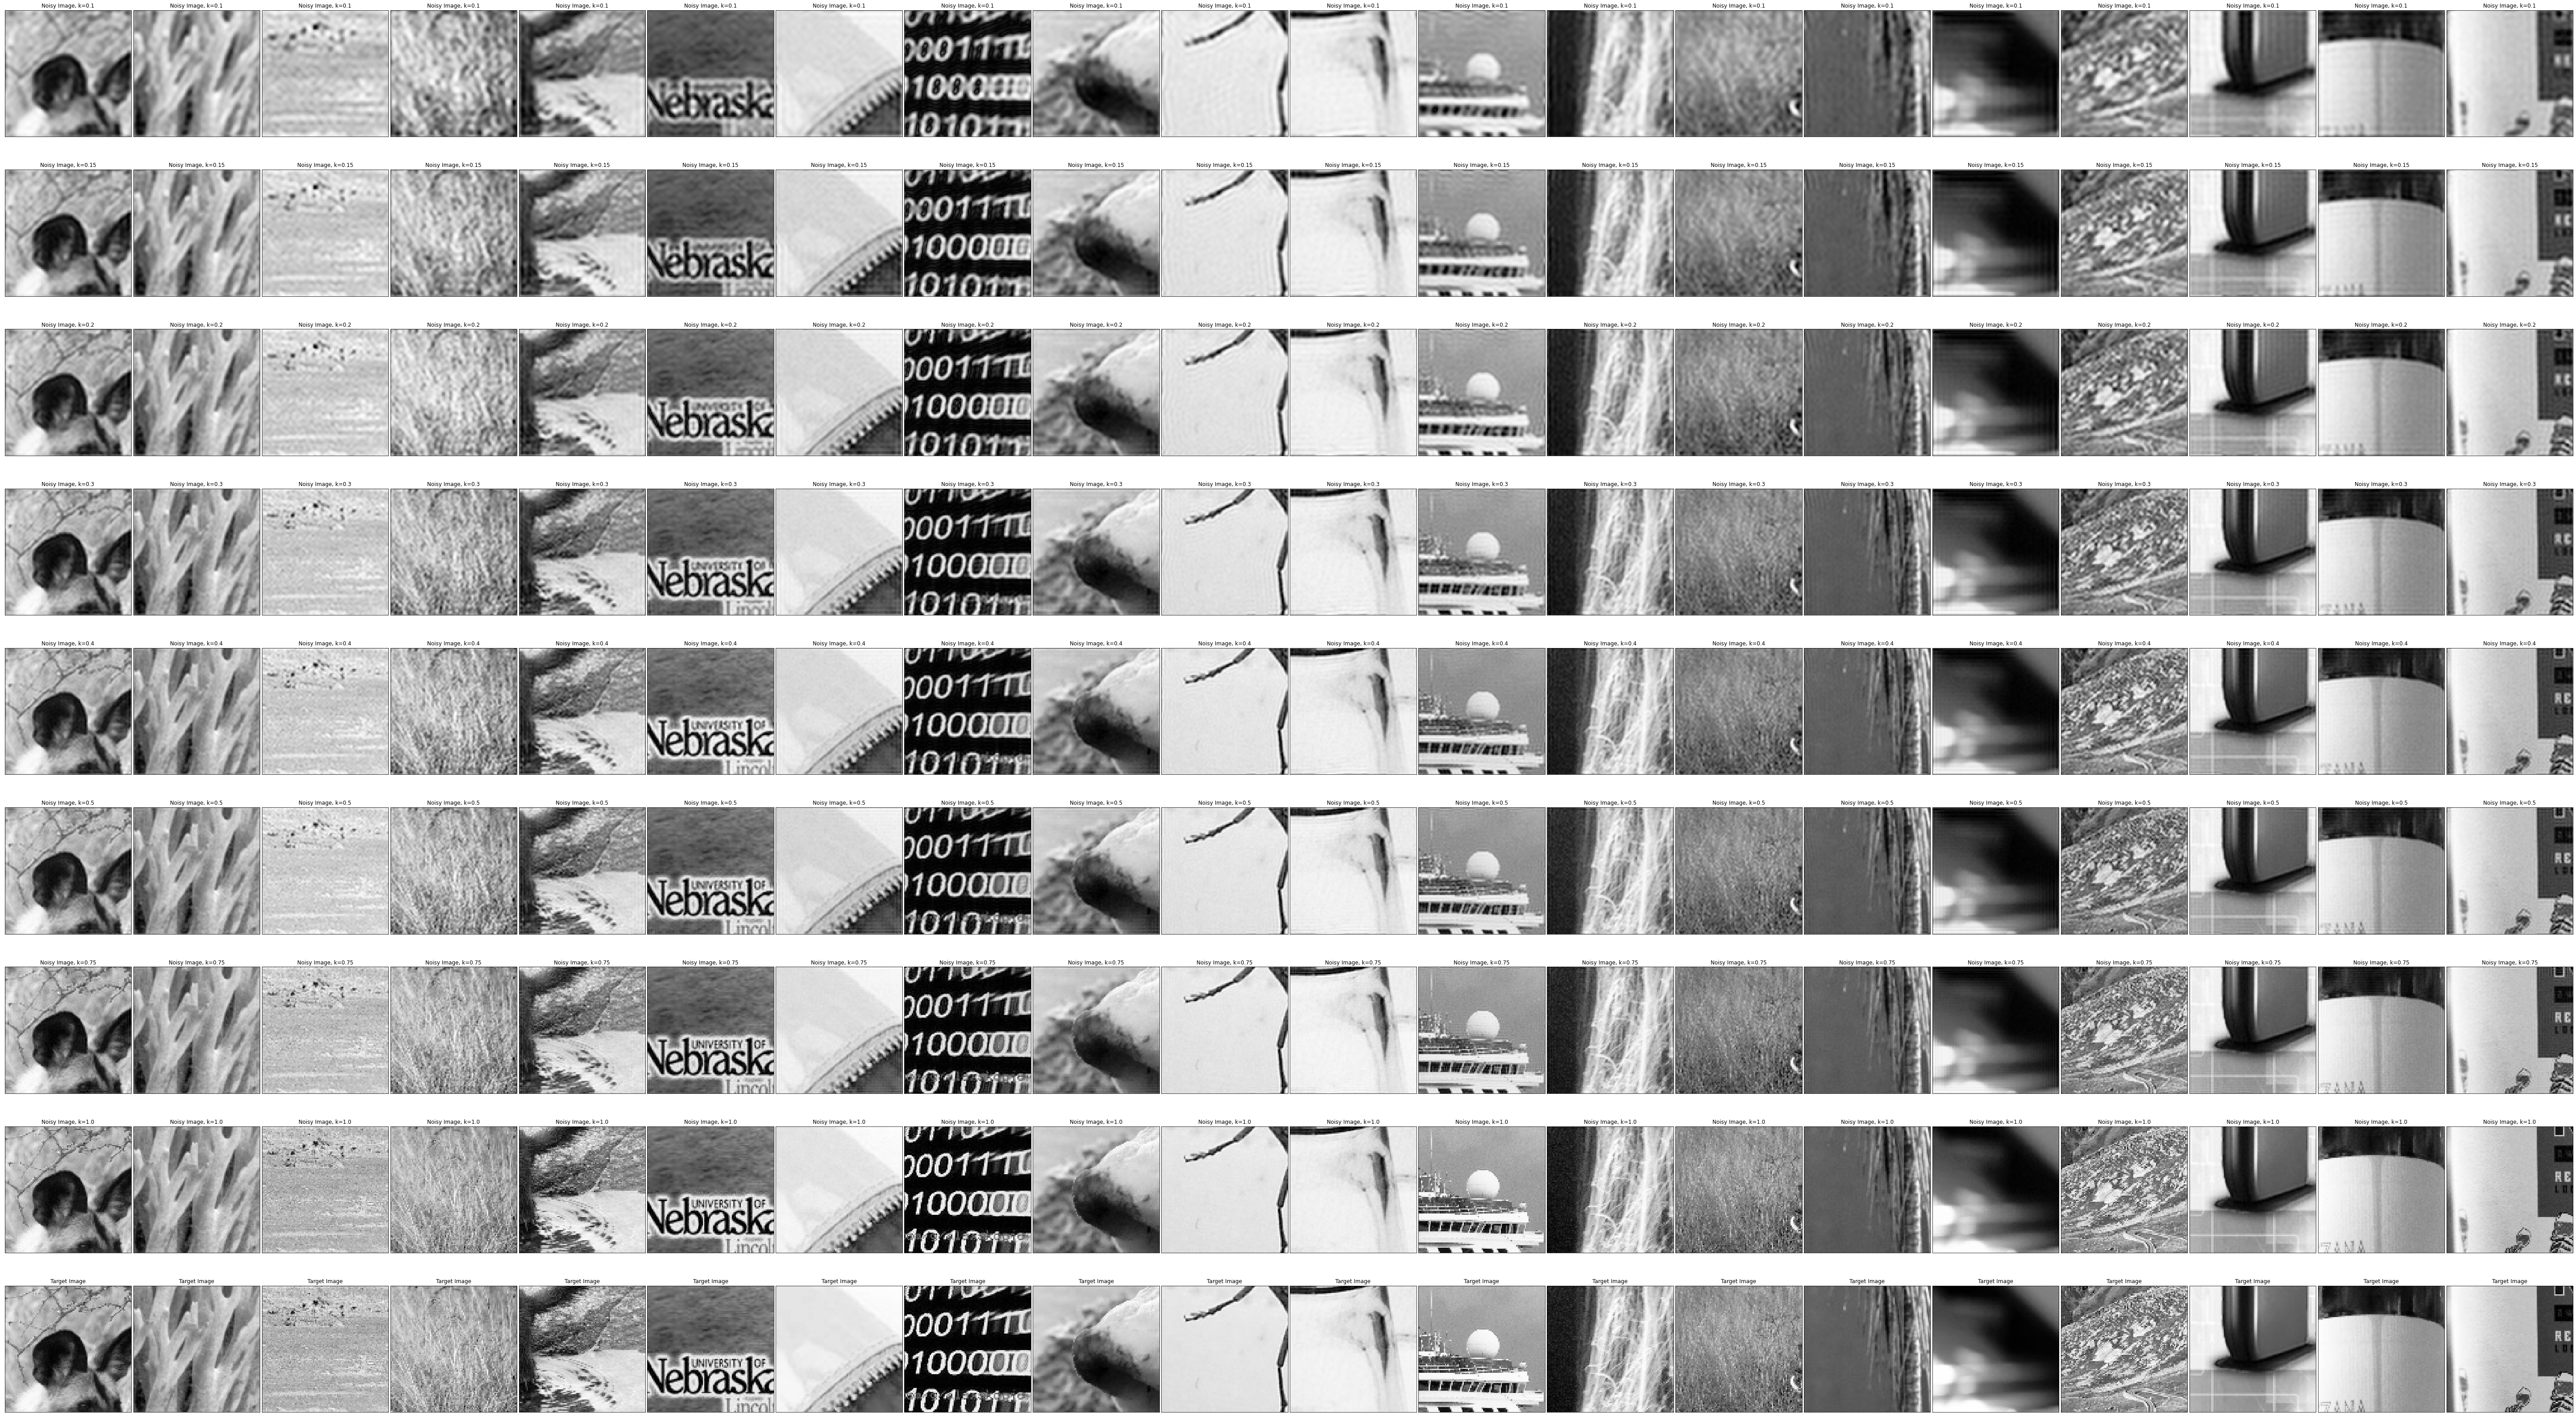

In [4]:
titles = [f'Noisy Image, k={x["k_factor"]}' for x in image_ids]
titles += ['Target Image'] * len(original_images)
images_to_display = noisy_images + original_images
plot_image_grid(images_to_display, titles, ncols=number_of_images)
plt.show()

# Apply Deep Decoder

In [5]:
fit_model_configuration = get_fit_model_configuration()
fit_model_configuration.image_dimensions = [image_size]*2 + [1]
fit_model_configuration.log_frequency = 100
fit_model_configuration.number_of_iterations = 2800
fit_model_configuration.convergence_check_length = None

fit_model_configuration.input_shape = [14, 14]
fit_model_configuration.number_of_layers = 5
fit_model_configuration.number_of_hidden_channels = 40

fit_model_configuration.convergence_check = 500
fit_model_configuration.find_best = False
fit_model_configuration.save_losses = False

print(fit_model_configuration)

image_dimensions: [100, 100, 1]  
result_path: data/results/  
model_type: deep  
input_shape: [14, 14]  
number_of_layers: 5  
number_of_hidden_channels: 40  
number_of_iterations: 2800  
learning_rate: 0.1  
convergence_check_length: None  
log_frequency: 100  
find_best: False  
save_losses: False  
constant_input: False  
data_type: <class 'torch.cuda.FloatTensor'>  
convergence_check: 500  



In [ ]:
number_of_iterations = 10

untrained_model_images = []
for image_index, noisy_image in enumerate(noisy_images):
    iteration_images = []
    fitter = create_fitter_from_configuration(fit_model_configuration)
    for iteration_index in range(number_of_iterations):
        model = create_model_from_configuration(fit_model_configuration)
        log_prefix=f'Image {image_index+1}/{len(noisy_images)}, Iteration {iteration_index+1}/{number_of_iterations}: '
        fitter(model, noisy_image, log_prefix=log_prefix)
        iteration_images.append(fitter.get_best_image())
    untrained_model_images.append(np.mean(iteration_images, axis=0))

plot_image_grid(untrained_model_images, ['Untrained Model Image'] * len(untrained_model_images), ncols=number_of_images)
plt.show()

# Load & Apply Trained Model

In [ ]:
path = 'models/trained_models/unet_magintude_pffact_8_snrlog0-5_nlayers_10.pt'
trained_model = UNetWavelet(in_ch=1, out_ch=1)
trained_model.load_state_dict(torch.load(path))
trained_model = trained_model.type(dtype)
trained_model = trained_model.eval()
for param in trained_model.parameters():
    param.requires_grad = False
#print(list(trained_model.parameters())[0].shape)
#summary(trained_model, (1, 100, 100), dtypes=[torch.cuda.FloatTensor], depth=3)

In [ ]:
trained_model_images = []
for noisy_image in noisy_images:
    noisy_tensor = image_to_tensor(noisy_image).unsqueeze(0).type(dtype)
    trained_image = trained_model(noisy_tensor)
    trained_model_image = tensor_to_image(trained_image.cpu().squeeze(0))
    trained_model_images.append(trained_model_image)

plot_image_grid(trained_model_images, ['Trained Model Image'] * len(trained_model_images), ncols=number_of_images)
plt.show()

#  Calculate & Compare Performances

In [ ]:
performances = []
for (noisy, trained, untrained, target, id) in zip(noisy_images, trained_model_images, untrained_model_images, target_images, image_ids):
    performances.append(performance_from_images(noisy, target, {'type': 'noisy', **id}))
    performances.append(performance_from_images(trained, target, {'type': 'trained', **id}))
    performances.append(performance_from_images(untrained, target, {'type': 'untrained', **id}))
avg_performances = average_performances(performances, ['type', 'k_factor'])

In [ ]:
def generate_plot_vectors(perfs, filter_value, y_key, filter_key='type', x_key='k_factor'):
    filtered_list =  list(filter(lambda x: x['id'][filter_key]==filter_value, perfs))
    x_vec = [x['id'][x_key] for x in filtered_list]
    y_vec = [y[y_key] for y in filtered_list]
    return x_vec, y_vec

In [ ]:
measures = [key for key in performances[0].keys() if key != 'id']
figure, axes = plt.subplots(1, len(measures), figsize=(len(measures)*6, 6))

for index, (axis, measure) in enumerate(zip(axes, measures)):
    for image_type in ['noisy', 'trained', 'untrained']:
        x_vec, y_vec = generate_plot_vectors(avg_performances, image_type, measure)
        axis.plot(x_vec, y_vec, label=image_type)
    axis.legend()
    axis.set_title(measure.upper())

plt.show()                  